## 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pylab as plt

print(tf.__version__)

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.10.0


## 下载IMDB数据集
我们将使用包含来自Internet 电影数据库的5万电影评论文本的IMDB 数据集。这些都分为2.5万项培训评论和2.5万项测试审查。训练和测试集是平衡的, 这意味着它们包含同样数量的正面和负面的评论。

IMDB 数据集是用 TensorFlow 包装的。已经对其进行了预处理, 以便将审阅 (单词序列) 转换为整数序列, 其中每个整数表示字典中的特定单词。

In [2]:
imdb = keras.datasets.imdb
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=10000)

### 探索数据

In [3]:
print('Train entires:{},label:{}'.format(len(train_data),len(train_labels)))

Train entires:25000,label:25000


In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
len(train_data[0]),len(train_data[1])

(218, 189)

### 将整数转换回单词

In [6]:
# 将单词映射到整数索引的字典
word_index = imdb.get_word_index()

# 第一个指数是保留的
# key  to value
word_index = {k:(v+3) for k,v in word_index.items()} 

word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

#value  to key
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i) for i in text])

In [7]:
# a={'fawn': 34701, 'tsukino': 52006, 'nunnery': 52007, 'sonja': 16816, 
#    'vani': 63951, 'woods': 1408, 'spiders': 16115, 'hanging': 2345, 
#    'woody': 2289, 'trawling': 52008, "hold's": 52009, 'comically': 11307, 
#    'localized': 40830, 'disobeying': 30568, "'royale": 52010, "harpo's": 40831, 
#    'canet': 52011, 'aileen': 19313, 'acurately': 52012, "diplomat's": 52013,
#    'rickman': 25242, 'arranged': 6746, 'rumbustious': 52014, 'familiarness': 52015, 
#    "spider'": 52016, 'hahahah': 68804, "wood'": 52017, 'transvestism': 40833, 
#    "hangin'": 34702}
# reverse_word_index = dict([(value, key) for (key, value) in a.items()])
# print(reverse_word_index)    

In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## 准备数据

评论 - 整数数组 - 必须在输入神经网络之前转换为张量。这种转换可以通过以下两种方式完成：

- 对数组进行单热编码，将其转换为0和1的向量。例如，序列[3,5]将成为10,000维向量，除了索引3和5（它们是1）之外全部为零。然后，将其作为我们网络中的第一层 - 一个可以处理浮点矢量数据的Dense层。然而，这种方法是存储器密集型的，需要num_words * num_reviews大小矩阵。

- 或者，我们可以填充数组，使它们都具有相同的长度，然后创建一个整数张量的形状max_length * num_reviews。我们可以使用能够处理这种形状的嵌入层作为我们网络中的第一层。

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [10]:
len(train_data[0]),len(train_data[1])

(256, 256)

In [11]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 建立模型
这些图层按顺序堆叠以构建分类器：

- 第一层是Embedding一层。该层采用整数编码的词汇表，并为每个词索引查找嵌入向量。这些向量是作为模型训练学习的。向量为输出数组添加维度。得到的尺寸是：(batch, sequence, embedding)。
- 接下来，GlobalAveragePooling1D通过对序列维度求平均，层为每个示例返回固定长度的输出向量。这允许模型以最简单的方式处理可变长度的输入。
- 这个固定长度的输出矢量通过一个Dense带有16个隐藏单元的完全连接（）层传输。
最后一层与单个输出节点密集连接。使用sigmoid激活函数，此值是介于0和1之间的浮点数，表示概率或置信度。

In [12]:
vocab_size = 10000
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,16))
#1D平均池化
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16,activation=tf.nn.relu))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


## 损失函数和优化器

In [13]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

## 创建验证集

In [14]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## 训练模型

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 75us/step - loss: 0.6969 - acc: 0.5043 - val_loss: 0.6922 - val_acc: 0.5250
Epoch 2/40
15000/15000 [==============================] - 1s 58us/step - loss: 0.6912 - acc: 0.5629 - val_loss: 0.6905 - val_acc: 0.5855
Epoch 3/40
15000/15000 [==============================] - 1s 63us/step - loss: 0.6894 - acc: 0.6105 - val_loss: 0.6890 - val_acc: 0.5821
Epoch 4/40
15000/15000 [==============================] - 1s 59us/step - loss: 0.6874 - acc: 0.6498 - val_loss: 0.6869 - val_acc: 0.6430
Epoch 5/40
15000/15000 [==============================] - 1s 60us/step - loss: 0.6848 - acc: 0.6407 - val_loss: 0.6843 - val_acc: 0.6850
Epoch 6/40
15000/15000 [==============================] - 1s 61us/step - loss: 0.6815 - acc: 0.7168 - val_loss: 0.6808 - val_acc: 0.7194
Epoch 7/40
15000/15000 [==============================] - 1s 60us/step - loss: 0.6771 - acc: 0.7288 - val_loss: 0.6762 - val_acc

## 评估模型

In [16]:
results = model.evaluate(test_data,test_labels)

print(results)

25000/25000 [==============================] - 0s 18us/step
[0.30718892672538756, 0.87352]


## 创建一段时间内准确性和损失图表
model.fit()返回一个History包含字典的对象，其中包含训练期间发生的所有事情：

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

有四个条目：在培训和验证期间，每个条目对应一个受监控的指标。我们可以使用这些来绘制训练和验证损失以进行比较，以及培训和验证准确性：

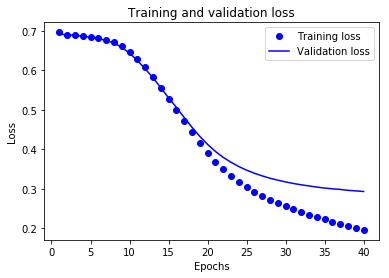

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

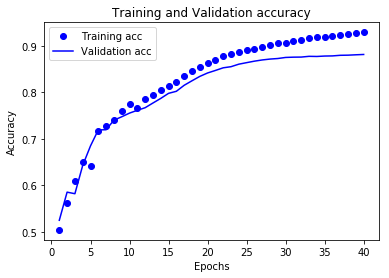

In [19]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()